## Data processing for d3 figures  and GTFS data filtering

In [1]:
# imports
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from shapely.geometry import shape, Point


DATAFOLDER = 'data'
warnings.filterwarnings("ignore")

data source https://opentransportdata.swiss/en/dataset/timetable-2020-hrdf

In [2]:
# read the .txt file and split the schedules by the separator '*Z '
with open(DATAFOLDER + "/2020_03_01/FPLAN") as schedules:
    text = schedules.read()
result = text.split('*Z ')

In [3]:
def int_list_time(a):
    l = []
    name = ''
    for i in a:
        if i.lstrip("-").isdigit():
            if len(i) == 5 or len(i) ==6:
                l.append(i)
        else:
            name += i
    return l, name           

In [4]:
# format the .txt file results
sch_number, route_number, transport_type, start_st_id, end_st_id, passing_st_ids, passing_st_names, st_arr_times, st_dep_times = ([] for i in range(9))
for i in result[1:]:    
    a = i.split('*')
    # get the identical information about schedule 
    schedule_id = a[0].split()
    route_number.append(schedule_id[0])
    sch_number.append(schedule_id[-2])
    # get the identical information about route 
    route_info = a[1].split()
    transport_type.append(route_info[1])
    start_st_id.append(route_info[2])
    end_st_id.append(route_info[3])
    st_id, station_name, arr_time, dep_time = ([] for i in range(4))
    # the route detail
    overall_sch = a[-1].split('%\n')[1:-1]
    for j in overall_sch:
        route = j.strip().split()
        st_id.append(route[0])
        time, station_name = int_list_time(route)
        arr_time.append(time[0])
        dep_time.append(time[-1])
    passing_st_ids.append(st_id)
    passing_st_names.append(station_name)
    st_arr_times.append(arr_time)
    st_dep_times.append(dep_time)

In [5]:
# making the dataframe from obtained lists 
data_dict = {'schedule_id': sch_number, 'route_number': route_number,'transport_type': transport_type,
            'start_station_ID': start_st_id,'end_station_ID': end_st_id, 'route_start_time': [time[0] for time in st_arr_times],
             'route_end_time': [time[-1] for time in st_dep_times],
            'passing_station_IDS': passing_st_ids,
            'passing_st_names': passing_st_names, 'arrival_times':st_arr_times, 'departure_times': st_dep_times}
data = pd.DataFrame.from_dict(data_dict)
# format the date
data.route_start_time = abs(data.route_start_time.astype(int)/100)%24
data.route_end_time = abs(data.route_end_time.astype(int)/100)%24
data.head()

,schedule_id,route_number,transport_type,start_station_ID,end_station_ID,route_start_time,route_end_time,passing_station_IDS,passing_st_names,arrival_times,departure_times
0,12607908707,04700,RE,8014309,8014228,4.47,5.40,"[8014309, 8014289, 8014288, 8014283, 8014281, ...",KarlsruheHbf,"[00447, 00452, 00456, 00501, 00506, 00513, 005...","[00447, 00453, 00457, 00502, 00507, 00514, 005..."
1,12606485457,04701,RE,8014228,8014309,4.56,5.41,"[8014228, 8014241, 8014245, 8014277, 8014281, ...",Offenburg,"[00456, 00505, 00509, 00515, 00521, 00526, 005...","[00456, 00505, 00510, 00516, 00522, 00527, 005..."
2,12605476307,04702,RE,8014309,8014228,5.46,6.39,"[8014309, 8014289, 8014288, 8014283, 8014281, ...",KarlsruheHbf,"[00546, 00550, 00555, 00559, 00604, 00611, 006...","[00546, 00551, 00555, 00600, 00605, 00612, 006..."
3,12611010807,04703,RE,8014521,8014586,5.51,7.25,"[8014521, 8014529, 8014533, 8014534, 8014554, ...",Konstanz,"[00551, 00601, 00609, 00615, 00632, 00635, 006...","[00551, 00602, 00610, 00619, 00633, 00636, 006..."
4,12610946707,04704,RE,8014521,8014228,5.35,7.50,"[8014521, 8014518, 8014513, 8014511, 8014502, ...",KarlsruheHbf,"[00535, 00543, 00557, 00611, 00619, 00625, 006...","[00535, 00544, 00558, 00612, 00621, 00626, 006..."


In [6]:
print("The number of available schedules until 2020 March 1st for a day in Switzerland: {}".format(data.shape[0]))

The number of available schedules until 2020 March 1st for a day in Switzerland: 473233


In [7]:
# map into several transport types 
trains = ['ICE', 'TGV', 'RJ', 'EC', 'IC', 'IR', 'PE', 'RE','EN', 'S','KB','BP','SN', 'R', 'ARZ', 'EXT', 'NJ', 'IRE','RJX', 'RB', 'CC','TER', 'BN']
fun = ['FUN', 'PB', 'SL']
metro = ['M']
bus = ['B', 'CAR', 'EXB','RUB']
ship = ['BAT', 'FAE']
tram = ['T', 'TE2']
gondola = ['GB', 'ASC']

data['transport_type'][data.transport_type.isin(trains)] = 'train'
data['transport_type'][data.transport_type.isin(fun)] = 'fun'
data['transport_type'][data.transport_type.isin(metro)] = 'metro'
data['transport_type'][data.transport_type.isin(bus)] = 'bus'
data['transport_type'][data.transport_type.isin(ship)] = 'ship'
data['transport_type'][data.transport_type.isin(tram)] = 'tram'
data['transport_type'][data.transport_type.isin(gondola)] = 'gondola'

In [8]:
tr_type = data.groupby(['transport_type']).size().reset_index(name='number_of_schedules')

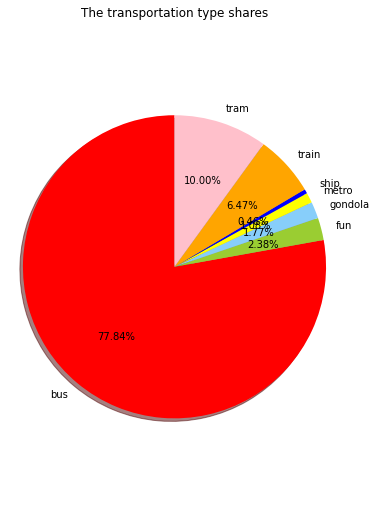

In [9]:
plt.figure(figsize=(6,9)) 
name_list = tr_type.transport_type
num_list = tr_type.number_of_schedules
labels = name_list 
sizes = num_list 
colors = ['red','yellowgreen','lightskyblue','yellow',"blue","orange","pink"] 
explode = (0,0,0,0,0,0,0) 
patches,text1,text2 = plt.pie(sizes,
                      explode=explode,
                      labels=labels,
                      colors=colors,
                      autopct = '%3.2f%%', 
                      shadow = True, 
                      startangle =90, 
                      pctdistance = 0.6) 
plt.axis('equal')
plt.title('The transportation type shares')
plt.show()

## Prepare data for Time Radial Histogram

In [10]:
time_data = data[["route_number", "transport_type", "route_start_time", "route_end_time"]]
print("The number of not-duplicated available schedules until 2020 March 1st for a day in Switzerland: {}".format(time_data.shape[0]))

The number of not-duplicated available schedules until 2020 March 1st for a day in Switzerland: 473233


In [11]:
def round_hour(hour, how_to = 'hourly'):
    int_hour = int(hour)
    mins = hour - int_hour
    if how_to == 'hourly':
        return int_hour
    if how_to == 'half_hourly':
        return round(int_hour + (0.3 if mins >= 0.3 else 0), 2)
    if how_to == 'quarter_hourly':
        return round(int_hour + (0.15 if mins >= 0.15 else 0) + (0.15 if mins >= 0.3 else 0)+ (0.15 if mins >= 0.45 else 0),2)

In [13]:
time_data['start_hourly'] = time_data.apply(lambda x: round_hour(x.route_start_time, 'hourly'), axis=1)
time_data['start_half_hourly'] = time_data.apply(lambda x: round_hour(x.route_start_time, 'half_hourly'), axis=1)
time_data['start_quarter_hourly'] = time_data.apply(lambda x: round_hour(x.route_start_time, 'quarter_hourly'), axis=1)

time_data['end_hourly'] = time_data.apply(lambda x: round_hour(x.route_end_time, 'hourly'), axis=1)
time_data['end_half_hourly'] = time_data.apply(lambda x: round_hour(x.route_end_time, 'half_hourly'), axis=1)
time_data['end_quarter_hourly'] = time_data.apply(lambda x: round_hour(x.route_end_time, 'quarter_hourly'), axis=1)

In [14]:
def get_data(time_var = 'hourly'):
    s = time_data.groupby(['start_{}'.format(time_var)]).size().reset_index(name = 'starting')
    e = time_data.groupby(['end_{}'.format(time_var)]).size().reset_index(name = 'ending')
    t_data = pd.merge(s, e, how='left', left_on= 'start_{}'.format(time_var), right_on = 'end_{}'.format(time_var))[['start_{}'.format(time_var), 'starting', 'ending']]
    t_data.rename(columns={'start_{}'.format(time_var): 'time'}, inplace=True)
    return t_data

In [15]:
get_data(time_var = 'hourly').to_csv(DATAFOLDER +'/data_figures/hourly_start_end.csv', index=False)
get_data(time_var = 'half_hourly').to_csv(DATAFOLDER +'/data_figures/half_hourly_start_end.csv', index=False)
get_data(time_var = 'quarter_hourly').to_csv(DATAFOLDER +'/data_figures/quarter_hourly_start_end.csv', index=False)

In [16]:
example = get_data(time_var = 'half_hourly')

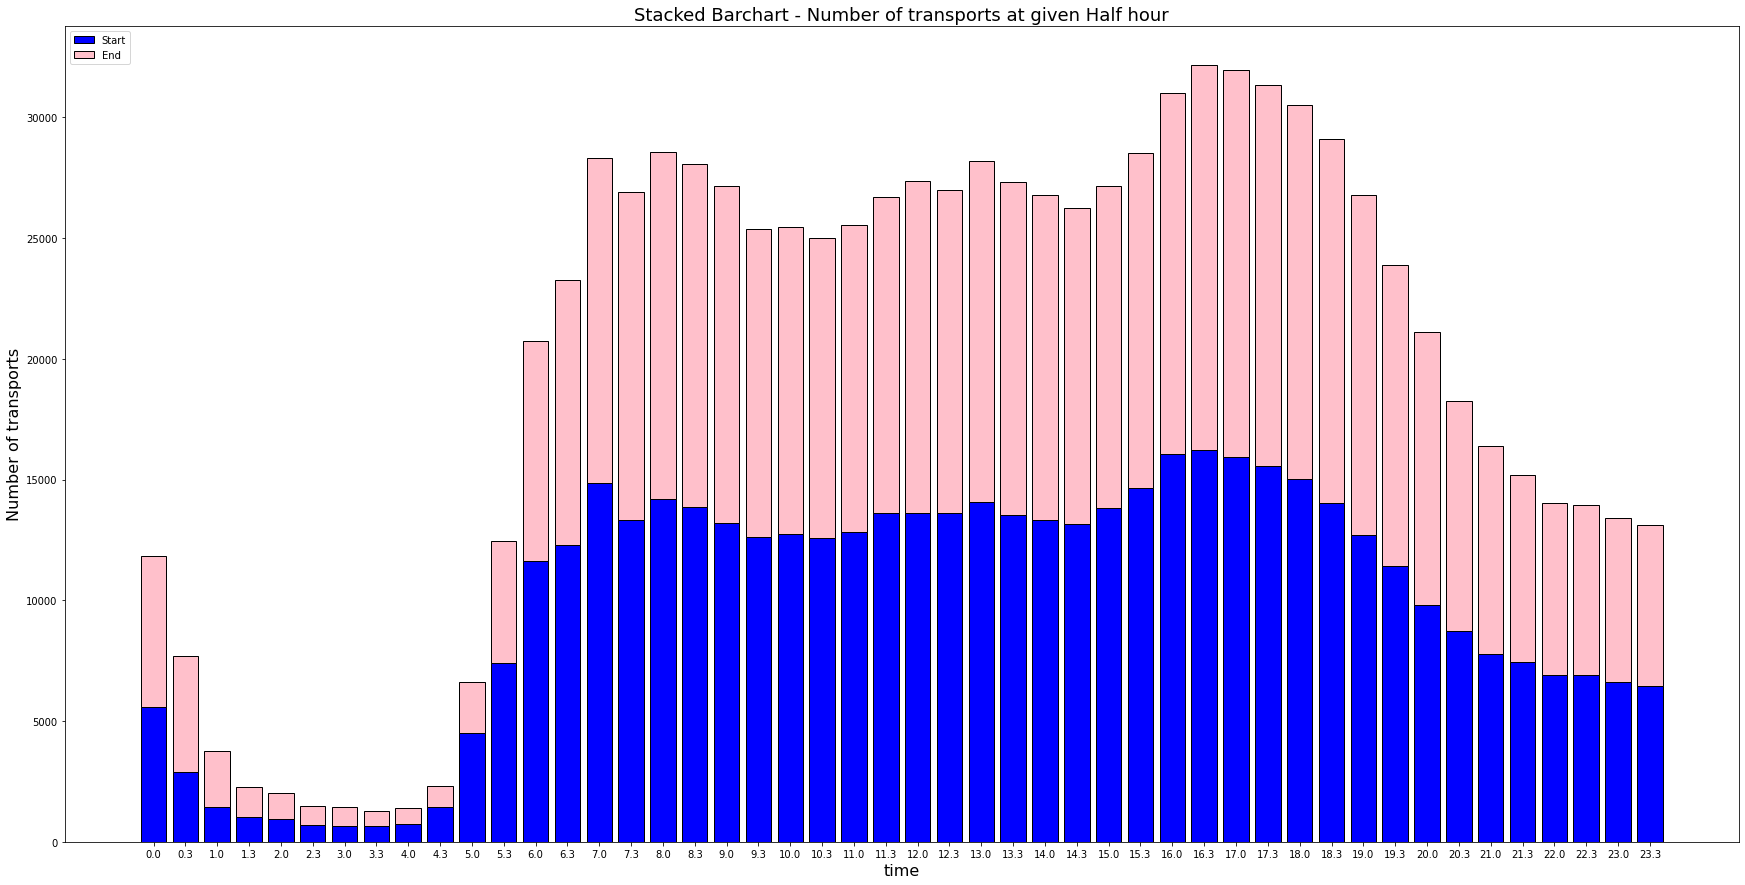

In [17]:
#plot an example
time=example.time.tolist()
classs=['Start','End']
pos = np.arange(example.shape[0])
starting_number=example.starting.tolist()
ending_number=example.ending.tolist()
 
plt.rcParams["figure.figsize"] = (30,15)

plt.bar(pos,starting_number,color='blue',edgecolor='black')
plt.bar(pos,ending_number,color='pink',edgecolor='black',bottom=starting_number)
plt.xticks(pos, time)
plt.xlabel('time', fontsize=16)
plt.ylabel('Number of transports', fontsize=16)
plt.title('Stacked Barchart - Number of transports at given Half hour',fontsize=18)
plt.legend(classs,loc=2)
plt.show()

In [18]:
with open(DATAFOLDER + "/2020_03_01/BFKOORD_GEO") as stations:
    text = stations.read()
result = text.split('\n')
st_id, lat, longt, number, name = ([] for i in range(5))
for i in range(len(result) - 1):
    each = result[i].split()
    st_id.append(each[0])
    longt.append(each[1])
    lat.append(each[2])
    number.append(each[3])
    name.append(' '.join(each[5:])) 
station_info = {'station_id': st_id, 'latitude': lat,'longitude': longt
               ,'number': number,'station_name': name}
stations = pd.DataFrame.from_dict(station_info)

stations.latitude= stations.latitude.astype(float)
stations.longitude= stations.longitude.astype(float)

with open(DATAFOLDER + '/dd_geojson_switzerland.json') as f:
    js = json.load(f)
    
# construct point based on lon/lat returned by geocoder
def get_canton(js, lat, long):
    point = Point(long, lat)
   # check each polygon to see if it contains the point
    for feature in js['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            return feature['properties']['name']
    return 'not in switzerland'
stations['canton'] = stations.apply(lambda row: get_canton(js, row.latitude, row.longitude), axis = 1)
suisse_stations = stations[stations.canton != 'not in switzerland']

## Prepare the data for Edge bundling

In [25]:
df = pd.read_excel(DATAFOLDER +'/passengers2018.xlsx')

# get the size of the data set
print("The data contains passenger capacity information for {} stations in Switzerland.".format(df.shape[0]))
# get some sample of the data
df.head()

The data contains passenger capacity information for 906 stations in Switzerland.


,Code,Bahnhof_Haltestelle,Kanton,Eigner,DTV_2018,DWV_2018,DNWV_2018,Bemerkungen,Remarques,Note,Remarks
0,AA,Aarau,AG,SBB,37900,44800,22700,Ohne AVA.,Sans AVA.,Senza AVA.,Without AVA.
1,AAT,Aathal,ZH,SBB,740,800,610,NaN,NaN,NaN,NaN
2,ABO,Aarburg-Oftringen,AG,SBB,2500,3000,1300,NaN,NaN,NaN,NaN
3,ACLA,Acla da Fontauna,GR,MGB,90,90,80,NaN,NaN,NaN,NaN
4,AD,Aadorf,TG,SBB,1700,2000,1000,Durchschnittswert 2018 durch Streckensperrung ...,Valeur moyenne 2018 à la baisse en raison de l...,Valore medio 2018 compromesso dallo sbarrament...,Average value for 2018 impacted by line closure.


In [29]:
df_p = df.fillna(value=0)
df_p = df_p.rename(columns = {'Code':'station_code','Bahnhof_Haltestelle':'station_name', 'Kanton':'canton','DNWV_2018': 'capacity'})
big_stations = df_p[['station_code', 'station_name', 'canton', 'capacity']]

big_stations['capacity'] = big_stations['capacity'].replace('<50','49')
#change the type of value in the data set
big_stations['capacity'] = big_stations['capacity'].astype('int')

In [30]:
big_stations.head()

,station_code,station_name,canton,capacity
0,AA,Aarau,AG,22700
1,AAT,Aathal,ZH,610
2,ABO,Aarburg-Oftringen,AG,1300
3,ACLA,Acla da Fontauna,GR,80
4,AD,Aadorf,TG,1000


In [31]:
big_stations = big_stations.sort_values('capacity', ascending = False).head(300)[['station_code', 'station_name', 'canton']]

In [32]:
s.head()

,station_code,station_name,canton
898,ZUE,Zürich HB,ZH
79,BN,Bern,BE
462,LZ,Luzern,LU
105,BS,Basel SBB,BS
836,W,Winterthur,ZH


In [33]:
suisse_stations.head()

,station_id,latitude,longitude,number,station_name,canton
6,0000011,47.191698,7.389618,466,Grenchen,Solothurn
10,0000022,47.547412,7.589562,276,Basel,Basel-Stadt
11,0000024,46.937487,7.395237,561,Bern Bümpliz,Bern/Berne
24,0000059,47.659615,9.132979,403,Tägerwilen,Thurgau
29,0000085,47.018942,7.498927,527,Schönbühl,Bern/Berne


In [34]:
stations1 = pd.merge(big_stations, suisse_stations, how = "inner", on = 'station_name')
stations1 = stations1[["station_code","station_name","canton_x","latitude","longitude"]]

In [ ]:
def create_links(passing_st_ids):
    """Create the dict of links with frequency values"""
    links = []
    info = {}
    for i in range(len(passing_st_ids)):
        sorted_ids = sorted(passing_st_ids[i]) 
        for j in range(len(sorted_ids)):
            for k in range(j+1, len(sorted_ids)):
                info = {}
                info['source'] = sorted_ids[j]
                info['target'] = sorted_ids[k]
                info['value'] = 1
                links.append(info)
    return links
#links = create_links(passing_st_ids)
#a = pd.DataFrame.from_dict(links)
#d = a.groupby(['source','target'])['value'].sum().reset_index()

In [35]:
links = pd.read_csv(DATAFOLDER + '/data_figures/links.csv')

In [36]:
nodes = pd.merge(big_stations, stations, how='inner', left_on = 'station_name', right_on = 'station_name')
nodes = nodes[['station_code','canton_x', 'station_id']]
nodes.station_id = nodes.station_id.astype(int)

In [37]:
a = pd.merge(links, nodes, how ='inner', left_on = 'source', right_on = 'station_id')[['station_code','source','target', 'value' ]]
b = pd.merge(a,nodes, how ='inner', left_on = 'target', right_on = 'station_id' )

In [38]:
trips = b[['station_code_x','station_code_y','value']]
trips.rename(columns={'station_code_x': 'origin', 'station_code_y': 'destination', 'value':'count'}, inplace=True)
stations1.rename(columns={'station_code': 'code', 'station_name': 'name', 'canton_x': 'canton'}, inplace=True)
stations1.to_csv(DATAFOLDER +'/data_figures/stations.csv', index=False)
trips.to_csv(DATAFOLDER +'/data_figures/trips.csv', index = False)

## Data for Stations capacity

Data souce from https://opentransportdata.swiss/en/dataset/timetable-2020-gtfs/resource/559278ea-fd2a-4d93-a462-f9c6d7b69dae

In [39]:
routes =  pd.read_csv('data/gtfs_new_dataset/routes.txt')
trips = pd.read_csv('data/gtfs_new_dataset/trips.txt')
stop_times = pd.read_csv('data/gtfs_new_dataset/stop_times.txt')
shapes = pd.read_csv('data/gtfs_new_dataset/shapes.txt')
agency = pd.read_csv('data/gtfs_new_dataset/agency.txt')

In [41]:
routes = routes[['route_id','route_desc','route_type']]
trips = trips[['route_id', 'trip_id', 'trip_headsign']]
stop_times = stop_times[['trip_id','arrival_time','stop_id']]

In [42]:
stops_trips = pd.merge(stop_times, trips, on = 'trip_id')
stops_trips_routes = pd.merge(stops_trips, routes, on = 'route_id')

In [43]:
d = stops_trips_routes[['stop_id', 'arrival_time', 'route_type']]

In [44]:
d.stop_id = d.stop_id.str.split(':').str[0]

In [45]:
st = pd.merge(d, suisse_stations, how = 'inner', left_on='stop_id', right_on='station_id')

In [46]:
data = st[['station_id','station_name', 'longitude','latitude', 'route_type', 'arrival_time']]

In [47]:
time = data.arrival_time.str.split(':')
data['hour'] = ((time.str[0].astype(int))%24).astype(str)
#a = time.str[1].astype(int)
data['minute'] = '00'
data['arrival_time'] = data[['hour', 'minute']].apply(lambda x: ':'.join(x), axis=1)

In [48]:
data = data.groupby(['station_id','station_name', 'longitude','latitude','route_type','arrival_time','hour','minute']).size().reset_index(name='number_of_transport')

In [49]:
data['route_type'] = data['route_type'].replace(0,'tram')
data['route_type'] = data['route_type'].replace(1,'bus')
data['route_type'] = data['route_type'].replace(2,'train')
data['route_type'] = data['route_type'].replace(3,'train')
data['route_type'] = data['route_type'].replace(4,'subway')
data['route_type'] = data['route_type'].replace(5,'ferry')
data['route_type'] = data['route_type'].replace(6,'funicular')
data['route_type'] = data['route_type'].replace(7,'gondola')

In [50]:
data[data.route_type != 'bus'].to_csv(DATAFOLDER + "/data_figures/station_capacity_no_bus.csv", index=False)